In [1]:
import xarray as xr 
import cartopy
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
import cv2
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
import os 

# 读取数据

In [78]:
""" 
获取的数据：
    亮温： tbdata 
    经度： lon 
    纬度： lat 
"""
dir_pth = r"./data/"
all_datafiles_pth_list = os.listdir(dir_pth)
init_data_list  = []
tb_data_list = []
for i_file_pth in all_datafiles_pth_list:
    i_file_data = xr.open_dataset(dir_pth+i_file_pth)
    # 处理单个文件数据
    i_file_data.sel(lat = slice(-60, 60), lon =  slice(60, 180)   )  
    tbdata = i_file_data.irwin_cdr[0].to_numpy()   # 由于获取的数据是（1，lon, lat) 所有需转换成（lon, lat)， 且为numpy格式
    
    # 保存的数据
    init_data_list.append(i_file_data)    
    tb_data_list.append(tbdata)

lon = init_data_list[0].lon    # 每个文件的lon, lat 都一样，此处取第一个文件的lon, lat
lat = init_data_list[0].lat   


In [3]:
print(tb_data_list[0].shape)

(2000, 5143)


# 连续区域识别 

## 找出需要的亮温区,并获取组件信息

In [97]:
# 找边界
def get_Component_Info(tb): 
    """
    tb: 亮温数据，  二维numpy数组
    return: 
        stats: (labels_id_number, 5)
        labels ： 2 dimension  array ，与原数据tb据形状一样
    注意：
        1.labels_id 的总数可以通过 len(stats) 获得
        2. ##真实的值
            mask = np.isin(num_labels, match_TbValue_IdList)
            tbdata = np.where([mask], tb, np.nan)[0]
          ## 拿出stats， 利用上方类似的两行带代码， 也可以通过循环
        3. 所有的坐标其实都是原来数据的索引  ， 比如stats中的x, y 
    """

    # 找出所有Tb < 225K的像素
    _, cold_cores = cv2.threshold(tb, 225, 255, cv2.THRESH_BINARY_INV)
    cold_cores = cold_cores.astype(np.uint8)   # # 转换为8位无符号整型以便后续处理
    
    # 找出所有Tb < 241K的像素
    _, cold_regions = cv2.threshold(tb, 241, 255, cv2.THRESH_BINARY_INV)
    cold_regions = cold_regions.astype(np.uint8)
    
    # # 使用形态学膨胀操作扩展冷云区域、冷云核心，   也就是把边缘弄得精细一些。   
    # kernel = np.ones((1,1), np.uint8)  
    # cold_cores = cv2.dilate(cold_cores, kernel, iterations= 1)
    # cold_regions = cv2.dilate(cold_regions, kernel, iterations= 1)
    
    # 不同的组件识别获取 (对冷云区域进行了一个一个的独立)
    num_labels_regions, labels_regions, stats_regions, centroids_regions = cv2.connectedComponentsWithStats(cold_regions,  connectivity=8)


    # 获取符合亮温的 label id 
    match_TbValue_IdList = []
    for region_id in range(1, num_labels_regions):  # 跳过背景 (0)                                        
        i_part_region_mask = (labels_regions == region_id).astype(np.uint8)   # np.uint8 将布尔值转化为0或 1 
        both_exist_mask = (i_part_region_mask == 1) & (cold_cores== 255)   # 既存在 冷区域，又存在冷核
        if np.any(both_exist_mask ):    
           match_TbValue_IdList.append(region_id)   # 两个都存在保留， 冷区域
    return labels_regions, stats_regions, match_TbValue_IdList

In [69]:
labels_regions, stats_regions, match_TbValue_IdList = get_Component_Info(tb_data_list[0])

In [6]:
print(match_TbValue_IdList)  # 观察是否存在 label_id = 0 , 也就是背景 
print(stats_regions)  


[2, 3, 8, 9, 106, 124, 126, 142, 155, 179, 194, 214, 259, 269, 331, 336, 345, 368, 381, 401, 442, 450, 451, 455, 485, 549, 564, 593, 595, 596, 606, 608, 617, 628, 632, 653, 673, 699, 719, 732, 735, 737, 738, 739, 740, 742, 743, 745, 746, 750, 753, 756, 757, 759, 763, 764, 766, 769, 770, 772, 773, 774, 779, 783, 784, 788, 790, 793, 799, 801, 804, 806, 808, 810, 811, 812, 813, 820, 821, 825, 830, 831, 837, 838, 839, 846, 854, 858, 876, 883, 884, 891, 899, 903, 905, 907, 912, 913, 915, 916, 918, 920, 923, 926, 928, 929, 933, 937, 938, 940, 944, 946, 951, 953, 960, 961, 962, 966, 970, 972, 975, 977, 979, 992, 997, 998, 1011, 1014, 1015, 1017, 1020, 1025, 1027, 1029, 1030, 1031, 1032, 1038, 1040, 1045, 1046, 1060, 1065, 1066, 1069, 1085, 1088, 1089, 1096, 1097, 1098, 1100, 1105, 1106, 1108, 1109, 1113, 1114, 1117, 1125, 1128, 1132, 1133, 1138, 1140, 1143, 1144, 1147, 1153, 1155, 1156, 1158, 1159, 1161, 1166, 1171, 1174, 1176, 1183, 1184, 1187, 1190, 1195, 1196, 1202, 1205, 1214, 1215, 1217,

In [103]:
# print(np.isin(num_labels, matchTb_list))

In [108]:
# # 假设你有以下三张图像：
# mask = np.isin(num_labels, matchTb_list)
# data = np.where([mask], tb_data_list[0], 0)[0]
# print(mask.shape)
# print(data.shape)
# fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 一行三列
# # 第一张图: CCS Map
# axes[0].imshow(data, cmap='Accent')  # cmap用白色
# axes[0].set_title('CCS Map (Tb < 241K & Core Included)')
# axes[0].grid(True)
# 
# plt.show()

## 计算面积的函数

In [98]:
def get_RealAreaArray(tb, lat):
    """
    tb:  2 numpy array , 亮温数据
    lat: 从dataset中提取的经度
    :return 
        area_per_pixel_km2:  形状与tb对应
    """
     # 计算每个像素对应的真实面积（km²）      
    R = 6371             # 地球半径（km）
    dlon = 0.07          # Grid Sat B1 的分辨率 0.07度  * 0.07度
    dlat = 0.07
    dlon_rad = np.radians(dlon)  # 转换为弧度 , 弧度单位rad
    dlat_rad = np.radians(dlat)
    
    # 获取实际的面积, 单位km^2 
    area_per_pixel_km2 = np.zeros_like(tb, dtype=np.float32)
    for i in range(tb.shape[0]):  # 遍历每一行（纬度）
        lat_rad = np.radians(lat[i])  # 当前行的纬度（假设已知）
        area = (R ** 2) * dlon_rad * dlat_rad * np.cos(lat_rad)      # np.cos 需要弧度, 所以才转换的
        area_per_pixel_km2[i, :] = area
    return area_per_pixel_km2
    

In [80]:
pix_area_array = get_RealAreaArray(tb_data_list[0], lat)

In [86]:
print(pix_area_array.max())  # 单个像素最大60多 km2
print(pix_area_array.min())  # 单个像素最小20多 km2

60.58513
20.721334


## 判断面积和离心率

In [96]:
def match_AreaAndEllipse(tb,lat, Component_Info):
    """
    tb: 2 np array 
    lat: 从dataset中提取的经度
    :return 
        real_areas_km2  :是一维数组， 对应每个组件的真实面积
        match_AreaAndEllipse_IdList： 满足面积 >4e4, 离心率小于0.4 的label_id list 
    """
    # 获取各组件面积
    area_per_pixel_km2 = get_RealAreaArray(tb, lat)
    labels, stats, match_Tb_IdLidt = Component_Info  # 获取组件对应的信息 
    
    # 基于通过亮温区域获取组件的label id ,来判断符合条件的面积的label id
    real_areas_km2 = []
    for label_id in match_Tb_IdLidt:  #  match_Tb_IdLidt从亮温区域获取的label_id
        mask = (labels == label_id)
        real_area = np.sum(area_per_pixel_km2[mask])
        real_areas_km2.append(real_area)           # real_areas_km2 是列表， 每个元素对应每个组件的真实面积
    real_areas_km2 = np.array(real_areas_km2)      # 由列表转化为数组
    # 判断条件===============>>> 面积和离心率
    criteria_1 = 4e4
    
    match_Tb_IdLidt_copy = np.array(match_Tb_IdLidt)
    # 1. 真实面积大于4e4
    area_greater_4e4_ids = match_Tb_IdLidt_copy[real_areas_km2 >  criteria_1] 
    # 2. 根据面积拿到一组 像素label id ， 接着计算离心率， 判断离心率大于0.4
    match_AreaAndEllipse_IdList = []

    for i_label in area_greater_4e4_ids:  # 肯定背景标签0, 因为是经过Tb挑选， 得出来的label id
        y_coords, x_coords = np.where(labels == i_label)
        coords = np.column_stack((x_coords, y_coords))
        ellipse = cv2.fitEllipse(coords)    # 椭圆拟合的点一定要大于5， 但是按照筛选的条件，一般肯定要大于5个点的
        # 计算离心率  
        ellipse_eccentricity = np.sqrt(1 - (ellipse[1][0] / ellipse[1][1]) ** 2)
        # 符合离心率条件的 i_label 
        if ellipse_eccentricity > 0.4:
            match_AreaAndEllipse_IdList.append(i_label)
    match_AreaAndEllipse_IdList = np.array(match_AreaAndEllipse_IdList)
    
    """ 至此， 对于Tb< 数值、面积大于4e4km^2 且离心率大于0.4的判断   都完成了
        对应label_id  ：  输出 match_AreaAndEllipse_IdList
    """
    return  match_AreaAndEllipse_IdList
    # return     match_AreaAndEllipse_IdList,   real_areas_km2
 

In [10]:
# """ 这个函数还没有使用"""
# def get_lonlat_trans_coords(stats_coords_info,lon, lat,):
#     """ 根据输入的stats 坐标点 """
#     """
#     stats_coords_info:  list,例如[[x,y,w,h],], 该列表中的每个元素都是 [x,y,w,h]   
#     lon:  从dataset中裁剪的lon, 例如： init_data.lon
#     lat: 从dataset中裁剪的lat,例如： init_data.lat 
#     """
#     points_list = []
#     for i_point_info in stats_coords_info:
#         x_min, y_top, width, height = i_point_info
#         points = [
#         (lon[x_min].item(), lat[y_top ].item()  ),   # 左上
#         (lon[x_min + width].item() , lat[y_top ].item() ),   # 右上
#         (lon[x_min + width].item() , lat[y_top + height].item()),   # 右下
#         (lon[x_min].item(), lat[y_top + height].item())    # 左下
#          ]
#         points_list.append(points)

## 通过label_id ,获得对应框经纬度信息和框内真实数据

In [158]:
# a = np.array([
#     [1,2,3,4,5],
#     [6,7,8,9,1],
# ])
# 
# b = np.array([1,2])
# 
# print(np.isin(a, b))
# print("np.isin(a, b).shape", np.isin(a, b).shape)
# print("a.shape", a.shape)
# print("============"*20)
# print(np.where(np.isin(a, b), a, np.nan)) 

In [99]:
def get_dataBy_id(labels, stats, matched_LabelIdList ,tb ,lon,lat):
    """ 
    :param labels: 是一个二维数组， 形状与原始数据相同
    :matched_LabelIdList :  是一个一维数组， 也就是符合条件的id 
    :new_tb : 是二维数组， 得到真实的值
    """        
    # 获取干净的数据 
    mask = np.isin(labels,matched_LabelIdList)
    cleaned_tb = np.where( mask, tb,np.nan)

    # 获取框坐标 
    points_list = []   # 储存框经纬度
    current_boxes = []  # 储存x,y, w, h, area , label_id 
    for i_id in matched_LabelIdList:
        x_min, y_top, width, height, area = stats[i_id]
        # print("print(i_id)")
        # print(i_id)
        # print("matched_LabelIdList")
        # print(matched_LabelIdList)
        # print("===============================================")
        # print("print(x_min, y_top, width, height, area)")
        # print(x_min, y_top, width, height, area)
        # print("===============================================")
        points = [
        (lon[x_min].item(), lat[y_top ].item()  ),   # 左上
        (lon[x_min + width].item() , lat[y_top ].item() ),   # 右上
        (lon[x_min + width].item() , lat[y_top + height].item()),   # 右下
        (lon[x_min].item(), lat[y_top + height].item())    # 左下
         ]

        points_list.append((points, i_id))
        # current_boxes 每个元素都是stats元素的x, y, w, h, area, 以及 对应的 label_id
        current_boxes.append([x_min, y_top, width, height, area, i_id])
    # 变为numpy类型                                                 
    current_boxes = np.array(current_boxes)
    return cleaned_tb, points_list ,  current_boxes 


In [167]:
print(lon.shape)

(5143,)


In [88]:
Component_Info = get_Component_Info(tb_data_list[0])  # # labels, stats , matchTb_list
match_AreaAndEllipse_IdList, real_area_aft_Tb =  match_AreaAndEllipse(tb_data_list[0],lat, Component_Info)

In [92]:
print(real_area_aft_Tb.max()) 
print(real_area_aft_Tb.min())

2354933.2
52.2662


In [95]:
print(real_area_aft_Tb[real_area_aft_Tb > 4e4].min()/1e4)

4.050653125


In [73]:
cleaned_tb, points_list ,  current_boxes  = get_dataBy_id(Component_Info[0], Component_Info[1], 
                  match_AreaAndEllipse_IdList ,
                tb_data_list[0] ,lon,lat) 


In [74]:
print(cleaned_tb.shape)

(2000, 5143)


In [100]:
# 第一个时刻  、  第二个时刻 
# ccsmap, num_labels, labels, stats, centroids,criteria_1_mcs_label_id = match_AreaAndEllipse(tb)
# ccsmap2, num_labels2, labels2, stats2, centroids2 , criteria_1_mcs_label_id2 = match_AreaAndEllipse(tb2)
# ccsmap3, num_labels3 , labels3, stats3, centroids3 , criteria_1_mcs_label_id3 = match_AreaAndEllipse(tb3)
variable_t_labels_Id_list = []
variable_t_matchedLableId_list = [] 
variable_t_stats_list  = []
cleaned_tb_data_list = []
variable_t_points_list = []
variable_t_current_boxes_list = []
for i in range(len(tb_data_list)):
    print(i)
    Component_Info = get_Component_Info(tb_data_list[0])  # labels_regions, stats_regions, match_TbValue_IdList
    match_AreaAndEllipse_IdList = match_AreaAndEllipse(tb_data_list[i],lat, Component_Info)
    cleaned_tb, points_list ,  current_boxes  = get_dataBy_id(Component_Info[0], Component_Info[1], 
                  match_AreaAndEllipse_IdList ,tb_data_list[i] ,lon,lat)

    variable_t_labels_Id_list.append(Component_Info[0])
    variable_t_stats_list.append(Component_Info[1])
    variable_t_matchedLableId_list.append(match_AreaAndEllipse_IdList)
    cleaned_tb_data_list.append(cleaned_tb)
    variable_t_points_list.append(points_list)
    variable_t_current_boxes_list.append(current_boxes)

print("数据获取完毕")

0
1
2
数据获取完毕


## 实现不同时刻覆盖的识别

In [ ]:
# 1.检查面积
# 2. 使用冷核而不是冷区 

In [101]:
def calculate_overlap_area(rect1, rect2):
    """
    计算两个矩形的重叠面积。
    :param rect1: 第一个矩形，格式为 (x, y, width, height)
    :param rect2: 第二个矩形，格式为 (x, y, width, height)
    :return: 重叠面积。如果没有重叠，则返回0。
    """
    # 解包矩形参数
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    area1 = w1 * h1
    area2 = w2 * h2

    # 计算x轴方向上的重叠
    left = max(x1, x2)
    right = min(x1 + w1, x2 + w2)
    overlap_x = max(0, right - left)

    # 计算y轴方向上的重叠
    top = max(y1, y2)
    bottom = min(y1 + h1, y2 + h2)
    overlap_y = max(0, bottom - top)
    overlap_area = overlap_x * overlap_y
    ration1 = overlap_area/area1
    ration2 = overlap_area/area2
    return max(ration1, ration2)
# # # 示例调用
# rectA = (100, 150, 200, 100)  # 矩形A的坐标和尺寸
# rectB = (150, 175, 100, 150)  # 矩形B的坐标和尺寸
# 
# overlap_area = calculate_overlap_area(rectA, rectB)
# print("重叠面积:", overlap_area)   

In [18]:
"""  真正的iou计算"""
# def calculate_iou(box1, box2):
#     """
#     计算两个矩形框之间的 IoU。
#     box: (x, y, w, h)
#     """
#     x1, y1, w1, h1 = box1
#     x2, y2, w2, h2 = box2
# 
#     # 交集坐标
#     left = max(x1, x2)
#     right = min(x1 + w1, x2 + w2)
#     overlap_x = max(0, right - left)
# 
#     top = max(y1, y2)
#     bottom = min(y1 + h1, y2 + h2)
#     overlap_y = max(0, bottom - top)
# 
#     overlap_area = overlap_x * overlap_y
#     area1 = w1 * h1
#     area2 = w2 * h2
#     union_area = area1 + area2 - overlap_area
# 
#     if union_area == 0:
#         return 0.0
#     return overlap_area / union_area

'  真正的iou计算'

In [28]:
def draw_boximg(lon, lat, tbdata, points_list,centroids , criteria_1_mcs_label_id ):
    # 设置防止中文乱码
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 创建图形和投影设置
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.gridlines(draw_labels=True)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.COASTLINE)
    ax.set_extent([90, 180, -10, 30], crs=ccrs.PlateCarree())
    # 绘制图像数据
    img = ax.contourf(lon,lat , 
                      tbdata,
                      cmap="coolwarm", 
          transform=ccrs.PlateCarree())
    
    current_centroids = centroids[criteria_1_mcs_label_id]
    for i, points in enumerate(points_list):
        # 画出方框
        polygon = Polygon(points, 
                          closed=True, 
                          edgecolor='darkred',
                          facecolor='none', 
                          linewidth=1, 
                          transform=ccrs.PlateCarree())
        ax.add_patch(polygon)
    
        # 标记处 stats对应的点, 也就是画框的起始点   
        # x_min = current_boxes[:,0][i]
        # y_top = current_boxes[:,1][i]
        # ax.scatter(lon[x_min], lat[y_top],
        #            s=15, 
        #            c='b', 
        #            edgecolors='black', 
        #            linewidth=1,
        #            transform=ccrs.PlateCarree(),
        #            )
        
        # # 画出质心位置
        # i_centroid_x_index = current_centroids[i][0]     # 忽略背景
        # i_centroid_y_index = current_centroids[i][1]     # 忽略背景 
        # ax.scatter(lon[int(i_centroid_x_index)],   # 由于质心不一定为整数， 但是索引要求取整，故用int
        #            lat[int(i_centroid_y_index)],
        #        s=15, 
        #        c='g', 
        #        edgecolors='g', 
        #        linewidth=1,
        #        transform=ccrs.PlateCarree(),
        #        )
    
    plt.show()

In [20]:
def draw_track_box_img(lon, lat, tbdata, points_list  ):
    # 设置防止中文乱码
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 创建图形和投影设置
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.gridlines(draw_labels=True)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.COASTLINE)
    # ax.set_extent([90, 180, -10, 30], crs=ccrs.PlateCarree())
    # 绘制图像数据
    img = ax.contourf(lon,lat , 
                      tbdata,
                      cmap="coolwarm", 
          transform=ccrs.PlateCarree())
    
    for i, points in enumerate(points_list):
        # 画出方框
        polygon = Polygon(points, 
                          closed=True, 
                          edgecolor='blue',
                          facecolor='none', 
                          linewidth=1, 
                          transform=ccrs.PlateCarree())
        ax.add_patch(polygon)
    
        # 标记处 stats对应的点, 也就是画框的起始点   
        # x_min = current_boxes[:,0][i]
        # y_top = current_boxes[:,1][i]
        # ax.scatter(lon[x_min], lat[y_top],
        #            s=15, 
        #            c='b', 
        #            edgecolors='black', 
        #            linewidth=1,
        #            transform=ccrs.PlateCarree(),
        #            )
        
        # # 画出质心位置
        # i_centroid_x_index = current_centroids[i][0]     # 忽略背景
        # i_centroid_y_index = current_centroids[i][1]     # 忽略背景 
        # ax.scatter(lon[int(i_centroid_x_index)],   # 由于质心不一定为整数， 但是索引要求取整，故用int
        #            lat[int(i_centroid_y_index)],
        #        s=15, 
        #        c='g', 
        #        edgecolors='g', 
        #        linewidth=1,
        #        transform=ccrs.PlateCarree(),
        #        )
    
    plt.show()

In [21]:
# # 第一个时刻
# img1  = draw_boximg(lon, lat, criteria1_tbdata, points_list,centroids , criteria_1_mcs_label_id )
# img2 = draw_boximg(lon, lat, criteria1_tbdata2, points_list2,centroids2 , criteria_1_mcs_label_id2 )

## 对框进行追踪

In [102]:
"""  输入已知的框进行追踪  """      
def track_boxes( all_t_boxes, iou_threshold=0.5):
    """
    追踪当前帧的框到下一帧，并识别新出现的框和消失的框。
    all_t_boxes: list , 每个元素都代表着一个时刻的所有的框
    track_boxes: list , [x,y,w,h, area(像素个数), 像素的label_id] 
    :param iou_threshold: IoU 阈值，默认为 0.5
    :return: list 
    """ 
    init_t = 0     #  表示时刻，  真实的持续时间用 t * 3  , 因为GridSat B1的时间分辨率是 3h   
    total_tracked_ids = 0
    all_trac_framelist = []      # 储存所有时刻的轨迹信息
    

    # 初始化box, 给其 id ， t 和  box 坐标
    init_t_trac_framelist = []
    for i, i_box in enumerate(all_t_boxes[0]):
        # 给当前图片的框做标记
        boxes_frame = {
                    "total_time": init_t,           
                    "track_id": total_tracked_ids, 
                    "track_boxes": i_box.tolist()   # 保存初始图像的 x, y,w, h, 原始像素的label_id 
                                          }
        init_t_trac_framelist.append(boxes_frame)
        total_tracked_ids += 1
    all_trac_framelist.append(init_t_trac_framelist)
    print(" 初始化后的  total_tracked_ids： ", total_tracked_ids)
    
    # 从第二个时刻开始追踪
    for t in range(1, len(all_t_boxes)):  
        i_t_trac_framelist =[]       # 记录一个时刻的所有轨迹框 ， 也就是从 第二张 图开始记录  
        # 前后两个时刻的所有的框  
        current_boxes =  all_t_boxes[t-1]
        next_boxes = all_t_boxes[t]
        
        used_next_boxes = []  # 记录已被匹配的 next_boxes
        # 比较前、后两个时刻的框 
        for i in range(len(all_trac_framelist[t-1])):   # 也就是前一时刻的某一个框
            i_current_id = all_trac_framelist[t-1][i]["track_id"]  
            i_curren_box= all_trac_framelist[t-1][i]["track_boxes"]

            # 判断是否匹配的标准
            best_match_box = None
            best_iou = 0 
            for i_next_box in next_boxes:
                iou = calculate_overlap_area(i_curren_box[0:4], i_next_box[0:4])   # [:,0:4] ->提取x,y, w, h
                if iou > best_iou:
                    best_match_box = i_next_box  # 保存完整的x,y, w, h, area, 原始像素的label——id
                    best_iou = iou
            if best_iou >= iou_threshold:  
                # 同一片云， 赋予下一个时刻同样的id        
                next_boxes_frame = {
                        "total_time": t , 
                        "track_id": i_current_id, 
                        "track_boxes": best_match_box.tolist()   # 下一个时刻中与前一个时刻最匹配的 框     
                                  }
                i_t_trac_framelist.append(next_boxes_frame)
                used_next_boxes.append(best_match_box.tolist())  # 标记下一个图片中已使用, 也就是记录同一片云 

                # print("时刻t: ", t)
                # print("=========前后一对========")
                # print(i_curren_box)
                # print(best_match_box.tolist())
                # print("========================================")
                
                
                # if (i_current_id == 15):
                #     print("时刻t: ", t)
                #     print("=========新出现的框========")
                #     print("track_id = 15  的box")
                #     print(i_curren_box.tolist())
                #     print(best_match_box.tolist())
        
        # 赋予后一个时刻中 没有id 的框的信息 ，也就是相较于上一张图片，后一张图片中新出现的框
        for box in next_boxes:
            # if box.tolist()  in used_next_boxes:
            #     print("if box.tolist()  in used_next_boxes: ")
            #     print(box.tolist())


            if box.tolist() not in used_next_boxes:    # 如果不转化为 list， 那么 numpy数组和 列表的比较会报错     
                # if (box.tolist()[-1] == 453):
                #     print("时刻t: ", t)
                #     print("=========新出现的框========")
                #     print("出现了  label_id = 453的box")
                #     print(box.tolist())
                
                # print("========================================")
                # print(used_next_boxes)
                # print("====================================")

                # print(f"前一个total_tracked_ids:{total_tracked_ids} ")
                # # total_tracked_ids += 1      
                # print(f"更新一次后total_tracked_ids:{total_tracked_ids} ")
                new_boxes_frame ={
                     "total_time": t,        # 下个时刻没有了， 说明还是处于第0时刻
                     "track_id": total_tracked_ids , 
                     "track_boxes": box.tolist()  
                }
                i_t_trac_framelist.append(new_boxes_frame)
                # 更新 id 
                total_tracked_ids += 1  #  放在这里更新，   如果放在本次循环的开头就更新， 那么会导致 id 的重复
        # 储存整个时刻的框的信息 
        all_trac_framelist.append(i_t_trac_framelist)

    return all_trac_framelist


In [103]:

# 数据跟踪和打印    
result = track_boxes( variable_t_current_boxes_list, iou_threshold=0.5 )   


 初始化后的  total_tracked_ids：  75


In [104]:
for  i_t_all_frame in result:
    for i_box_info in i_t_all_frame:
        print(i_box_info)

{'total_time': 0, 'track_id': 0, 'track_boxes': [1273, 4, 118, 61, 2816, 3]}
{'total_time': 0, 'track_id': 1, 'track_boxes': [2016, 5, 225, 48, 3525, 4]}
{'total_time': 0, 'track_id': 2, 'track_boxes': [2235, 4, 565, 400, 70347, 5]}
{'total_time': 0, 'track_id': 3, 'track_boxes': [4455, 4, 462, 324, 42420, 14]}
{'total_time': 0, 'track_id': 4, 'track_boxes': [3105, 138, 74, 62, 2002, 161]}
{'total_time': 0, 'track_id': 5, 'track_boxes': [4267, 177, 264, 167, 14522, 202]}
{'total_time': 0, 'track_id': 6, 'track_boxes': [4078, 179, 168, 67, 6358, 206]}
{'total_time': 0, 'track_id': 7, 'track_boxes': [3093, 228, 323, 229, 14584, 241]}
{'total_time': 0, 'track_id': 8, 'track_boxes': [1912, 284, 319, 143, 19911, 354]}
{'total_time': 0, 'track_id': 9, 'track_boxes': [1780, 309, 210, 225, 13392, 455]}
{'total_time': 0, 'track_id': 10, 'track_boxes': [4962, 321, 66, 74, 1221, 490]}
{'total_time': 0, 'track_id': 11, 'track_boxes': [1201, 327, 197, 213, 17707, 506]}
{'total_time': 0, 'track_id':

In [32]:
def print_organized_tracks(all_trac_framelist, method='id'):
    """
    根据参数 method 展示 MCS 轨迹信息。
    参数:
        all_trac_framelist: track_boxes 返回的结果
        method: 
            - 'id': 按照轨迹 ID 展示（默认）
            - 't': 按照时间帧展示
    """
    if method == 'id':
        # 按照 MCS ID 组织数据
        tracks_by_id = {}  # {track_id: [(time, box)]}            
        for time_step in all_trac_framelist:
            t = time_step[0]["total_time"] if time_step else None
            for item in time_step:
                track_id = item["track_id"]
                time = item["total_time"]
                box = item["track_boxes"]

                if track_id not in tracks_by_id:
                    tracks_by_id[track_id] = []
                # tracks_by_id[track_id].append(box)
                tracks_by_id[track_id].append((time, box))
        
        # 打印按 ID 分组的轨迹
        for track_id in sorted(tracks_by_id.keys()):
            # print(tracks_by_id[track_id])  # 按照不同的id， 那出数据
            print(f"MCS ID: {track_id}")
            for time, box in tracks_by_id[track_id]:
                print(f"    Time {time} → {box}")
            print()

    elif method == 't':
        # 按照时间帧组织数据
        tracks_by_t = {}  # {time: [(track_id, box)]}

        for time_step in all_trac_framelist:
            t = time_step[0]["total_time"] if time_step else None
            if t is not None:
                if t not in tracks_by_t:
                    tracks_by_t[t] = []
                for item in time_step:
                    track_id = item["track_id"]
                    box = item["track_boxes"]
                    # tracks_by_t[t].append((track_id, box))  
                    tracks_by_t[t].append(box)  # 拿出 box 的坐标       

        # 打印按 时间帧 分组的轨迹
        for t in sorted(tracks_by_t.keys()):
            print("==="*10)
            # print(tracks_by_t[t])    
            print(f"时刻 t: {t}")
            for track_id, box in tracks_by_t[t]:
                print(f"    ID {track_id} → {box}")
            print()
    else:
        raise ValueError("method 必须是 'id' 或 't'")


## 对时间进行筛选

In [105]:
"""  至少存在2 个时刻 """          
def choice_t(all_trac_framelist):
    """ 
    all_trac_framelist: 该参数是根据 函数track_boxes 拿到的列表
    time_criteria: [[(t,box的x,y,w,h)], ...]
    by_time_list : list 
    """
    # 按照 ID 组织数据 , 也就是不同的框出现的个数
    tracks_by_id = {}  # {track_id: [(time, box)]} 
    time_criteria_list = []
    for time_step in all_trac_framelist:  # time_step 代表一个时刻的框
        for i_box in time_step:
            track_id = i_box["track_id"]
            t = i_box["total_time"]       # t表示时刻 
            box = i_box["track_boxes"]
            if track_id not in tracks_by_id:
                tracks_by_id[track_id] = []
            tracks_by_id[track_id].append((t,track_id, box))   # 将同一个id的框， 存储起来

    # 判断个数， 也就是 每个框存在了多少个时刻
    for track_id in sorted(tracks_by_id.keys()):
        if len(tracks_by_id[track_id]) >= 2:
            time_criteria_list.append(tracks_by_id[track_id])
            # print("tracks_by_id[track_id]======================================")
            # print(tracks_by_id[track_id])

    # 按时间整合数据， t, track_id,  像素的label_id 
    by_time = {}  # {t: [ (id, box), ... ]}
    for i_id_box in time_criteria_list:
        for t, track_id, box in i_id_box:
            if t not in by_time:
                by_time[t] = []
            by_time[t].append(box[-1])   # 获得追踪id 、 像素的label_id
            # print("=========================box[-1]===================")
            # print(track_id, box[-1])
    by_time_label_id_list = [
        by_time[t] for t in sorted(by_time.keys())
    ]
    
    # # 按照 track_id 拿出框
    # by_id = {}
    # for i_id_box in time_criteria_list:  #  
    #     for t, track_id, box in i_id_box:
    #         if track_id not in by_id:
    #             by_id[track_id] = []
    #         by_id[track_id].append(box[-1])   # 获得追踪id 、 像素的label_id
    # 
    #     by_id_label_id_list = [
    #                     by_id[i_track_id] for i_track_id in sorted(by_id.keys())]
    #     
    #     
        
    return by_time_label_id_list  #  by_time   拿出  label id 


In [28]:
# """ 将框信息 转化为可以对应的框的经纬度 """   
# def get_lonlat_trans_coords(stats_coords_info,lon, lat,):
#     """ 根据输入的stats 坐标点 """
#     """
#     stats_coords_info:  list,例如[[x,y,w,h],], 该列表中的每个元素都是 [x,y,w,h]   
#     lon:  从dataset中裁剪的lon, 例如： init_data.lon
#     lat: 从dataset中裁剪的lat,例如： init_data.lat 
#     """
#     points_list = []
#     for i_point_info in stats_coords_info:
#         x_min, y_top, width, height = i_point_info
#         points = [
#         (lon[x_min].item(), lat[y_top ].item()  ),   # 左上
#         (lon[x_min + width].item() , lat[y_top ].item() ),   # 右上
#         (lon[x_min + width].item() , lat[y_top + height].item()),   # 右下
#         (lon[x_min].item(), lat[y_top + height].item())    # 左下
#          ]
#         points_list.append(points)

In [106]:
print_organized_tracks(result)

MCS ID: 0
    Time 0 → [1273, 4, 118, 61, 2816, 3]
    Time 1 → [1273, 4, 118, 61, 2816, 3]
    Time 2 → [1273, 4, 118, 61, 2816, 3]

MCS ID: 1
    Time 0 → [2016, 5, 225, 48, 3525, 4]
    Time 1 → [2016, 5, 225, 48, 3525, 4]
    Time 2 → [2016, 5, 225, 48, 3525, 4]

MCS ID: 2
    Time 0 → [2235, 4, 565, 400, 70347, 5]
    Time 1 → [2235, 4, 565, 400, 70347, 5]
    Time 2 → [2235, 4, 565, 400, 70347, 5]

MCS ID: 3
    Time 0 → [4455, 4, 462, 324, 42420, 14]
    Time 1 → [4455, 4, 462, 324, 42420, 14]
    Time 2 → [4455, 4, 462, 324, 42420, 14]

MCS ID: 4
    Time 0 → [3105, 138, 74, 62, 2002, 161]
    Time 1 → [3105, 138, 74, 62, 2002, 161]
    Time 2 → [3105, 138, 74, 62, 2002, 161]

MCS ID: 5
    Time 0 → [4267, 177, 264, 167, 14522, 202]
    Time 1 → [4267, 177, 264, 167, 14522, 202]
    Time 2 → [4267, 177, 264, 167, 14522, 202]

MCS ID: 6
    Time 0 → [4078, 179, 168, 67, 6358, 206]
    Time 1 → [4078, 179, 168, 67, 6358, 206]
    Time 2 → [4078, 179, 168, 67, 6358, 206]

MCS ID: 

In [30]:
# cleaned_label_id_list = choice_t(result)
# # 获取所有时刻的 像素label id
# all_t_greater2_label_list = cleaned_label_id_list
# points_list_t_greater2 = []
# tb_data_list_t_greater2 = []
# centroid_tgreater2 =  []
# 
# for t in range(len(cleaned_label_id_list)):  # 拿出所有时刻的信息
#     final_mask = np.isin(variable_t_labels_list[t], all_t_greater2_label_list[t])
#     cleaned_tb = np.full_like(all_t_tbdata[t], np.nan)
#     cleaned_tb[final_mask] = all_t_tbdata[t][final_mask]
#     # 存取获得的亮温 
#     tb_data_list_t_greater2.append(cleaned_tb)
#     
#     # i_t_centroid_tgreater2 = []
#     # 对每个时刻的信息进行处理
#     i_t_points_list = []
#     for i_id in all_t_greater2_label_list[t]:
#         x_min, y_top, width, height, area = variable_t_stats_list[t][i_id]
#         # 获取对应的质心
#         # i_t_centroid_tgreater2.append( centroids_list[t][i_id])
#         points = [
#             (lon[x_min].item(), lat[y_top ].item()  ),   # 左上
#             (lon[x_min + width].item() , lat[y_top ].item() ),   # 右上
#             (lon[x_min + width].item() , lat[y_top + height].item()),   # 右下
#             (lon[x_min].item(), lat[y_top + height].item())    # 左下
#         ]
#         i_t_points_list.append((points, i_id))
#     
#     points_list_t_greater2.append((i_t_points_list))
#     # centroid_tgreater2.append(i_t_centroid_tgreater2)


In [ ]:
print(tb_data_list.shape)
print()

In [45]:
print(cleaned_tb_data_list[0].shape)

(5143,)


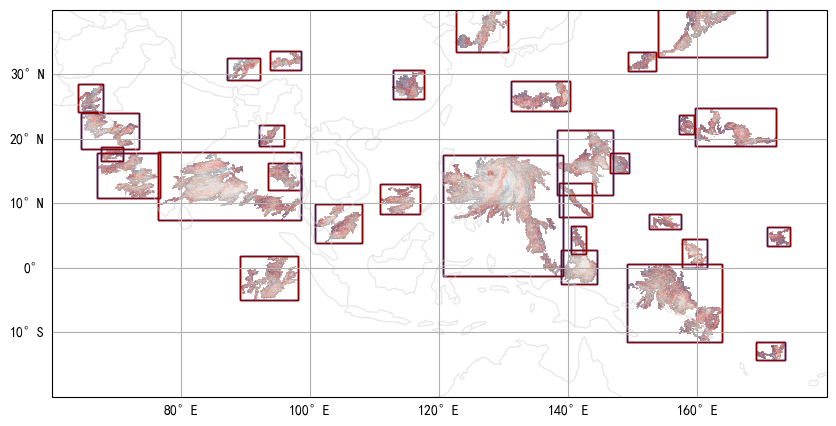

In [114]:
from matplotlib.patches import Polygon, FancyArrowPatch
from shapely.geometry import Polygon as ShapelyPolygon
# 创建图形和投影设置
fig, ax = plt.subplots(figsize=(10, 15), subplot_kw={'projection': ccrs.PlateCarree()})
grid = ax.gridlines(draw_labels=True)
grid.top_labels = False
grid.right_labels = False
ax.add_feature(cfeature.BORDERS, edgecolor='lightgray', alpha=0.5)
ax.add_feature(cfeature.COASTLINE, edgecolor='lightgray', alpha=0.5)
ax.set_extent([60, 180, -20, 40], crs=ccrs.PlateCarree())
# ax.set_extent([-60, 60, -20, 40], crs=ccrs.PlateCarree())
# ax.set_extent([-120, -60, -20, 40], crs=ccrs.PlateCarree())
# ax.set_extent([-60,60, -60, -20], crs=ccrs.PlateCarree())

cmap_list = ["binary", 'Blues', 'Reds']
color_list = ['gray', 'darkblue', 'darkred']

# 第一个时刻的方框
for i_t in range(len(tb_data_list)):
    # 画底图
    ax.contourf(lon,lat , cleaned_tb_data_list[i_t], 
                cmap=cmap_list[i_t], 
                alpha =  0.2,
                transform=ccrs.PlateCarree())

    # 画框
    i_points_list = variable_t_points_list[i_t]
    for points, i_label_id in i_points_list:
        # print(points, i_label_id)
        polygon = Polygon(points, closed=True, 
                          edgecolor=color_list[i_t],
                          facecolor='none', linewidth=1, transform=ccrs.PlateCarree())
        ax.add_patch(polygon)

         # 计算多边形中心点
        poly_center = ShapelyPolygon(points).centroid.coords[0]

        # # 在框内添加文本，比如索引号或者特定字符
        # ax.text(poly_center[0], poly_center[1], f"{i_label_id}", 
        #         fontsize=15, ha='center', va='center',
        #         color=color_list[i_t], transform=ccrs.PlateCarree())

# # 添加图例
legend_elements = [
    Line2D([0], [0], color='gray', lw=2, linestyle='-', label='t=0'),
    Line2D([0], [0], color='darkblue', lw=2, linestyle='-', label='t=1'),
    Line2D([0], [0], color='darkred', lw=2, linestyle='-', label='t=2'),
]

# ax.legend(handles=legend_elements, loc='upper right', fontsize=12)   
plt.savefig('./img/my_mcs_追踪图.png', bbox_inches='tight', dpi=300, pad_inches=0.1,  )

plt.show()

In [32]:
# # 画出 第三个文件的  label_id = 467 的框       
# criteria1_tbdata_llllll, points_list3, next_boxes3 = get_dataBy_id(labels3, criteria_1_mcs_label_id3 , stats3,tb3)
# img_test  = draw_boximg(lon, lat, criteria1_tbdata, points_list,centroids , criteria_1_mcs_label_id )

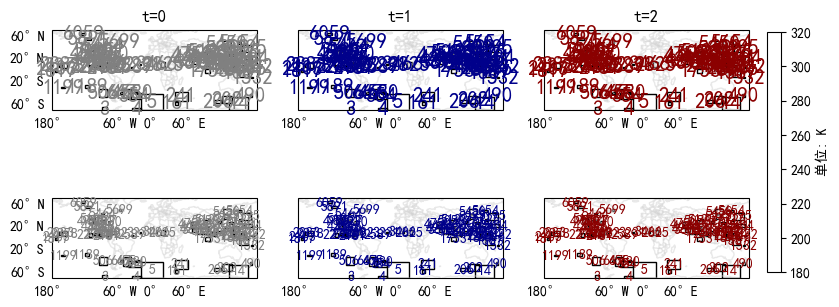

In [113]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D

# 防止中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 计算全局的最小值和最大值
# 将列表中的二维数据进行拼接
all_data = np.concatenate(tb_data_list)
global_min = min([data.min() for data in all_data])
global_max = max([data.max() for data in all_data])

fig, ax = plt.subplots(2, 3, figsize=(9, 4), 
                       subplot_kw={'projection': ccrs.PlateCarree()},
                       )
# plt.subplots_adjust(
#     left=0.1,
#     right=0.76,  # 为colorbar留出空间
#     bottom=0.1,
#     top=0.9,
#     wspace=0.25,
#     hspace= 0.01)

# 添加网格和底图元素
for i_row in range(ax.shape[0]):
    for i_col in range(ax.shape[1]):
        # 添加经纬度网格线并显示标签
        i_ax = ax[i_row, i_col]
        grid = i_ax.gridlines(draw_labels=True, linewidth=0)
        grid.top_labels = False
        grid.right_labels = False 
        if i_col == 0 :
            grid.left_labels = True
        else:
            grid.left_labels = False

        i_ax.add_feature(cfeature.BORDERS, edgecolor='lightgray', alpha=0.5)
        i_ax.add_feature(cfeature.COASTLINE, edgecolor='lightgray', alpha=0.5)
        # i_ax.set_extent([90, 180, -10, 30], crs=ccrs.PlateCarree())

cmap_list = ["binary", 'Blues', 'Reds']
color_list = ['gray', 'darkblue', 'darkred']

# 存储第一个 contourf 的实例以供创建共享 colorbar 使用
contourf_instance = None
extend = 'neither'  # 使用默认值
for i_t in range(len(tb_data_list)):
    for i in range(2):   # 两组图，一组为原图，一组为识别出来的图
        if i == 0:   # 原图
            contourf_plot = ax[i, i_t].contourf(lon, lat, tb_data_list[i_t],
                                                cmap='coolwarm',
                                                vmin=global_min,
                                                vmax=global_max,
                                                extend = extend,
                                                transform=ccrs.PlateCarree())
            ax[i, i_t].set_title(f't={i_t}')
            # 画上框 
            points_list = variable_t_points_list[i_t]
            for points, i_label_id in points_list:
                polygon = Polygon(points, closed=True,
                                  edgecolor='black',
                                  facecolor='none', linewidth=1, transform=ccrs.PlateCarree())
                ax[i, i_t].add_patch(polygon)
                 # 计算多边形中心点
                poly_center = ShapelyPolygon(points).centroid.coords[0]
        
                # 在框内添加文本，比如索引号或者特定字符
                ax[i, i_t].text(poly_center[0], poly_center[1], f"{i_label_id}", 
                        fontsize=15, ha='center', va='center',
                        color=color_list[i_t], transform=ccrs.PlateCarree())


            # 保存第一个 contourf 实例
            if contourf_instance is None:
                contourf_instance = contourf_plot

        else:   # 有框的图
            ax[i, i_t].contourf(lon, lat, cleaned_tb_data_list[i_t],
                                cmap='coolwarm',
                                vmin=global_min,
                                vmax=global_max,
                                extend = extend,
                                transform=ccrs.PlateCarree())

            points_list = variable_t_points_list[i_t]
            for points, i_label_id in points_list:
                polygon = Polygon(points, closed=True,
                                  edgecolor='black',
                                  facecolor='none', linewidth=1, transform=ccrs.PlateCarree())
                ax[i, i_t].add_patch(polygon)
                                 # 计算多边形中心点
                poly_center = ShapelyPolygon(points).centroid.coords[0]
        
                # 在框内添加文本，比如索引号或者特定字符
                ax[i, i_t].text(poly_center[0], poly_center[1], f"{i_label_id}", 
                        fontsize=10, ha='center', va='center',
                        color=color_list[i_t], transform=ccrs.PlateCarree())

            ## 添加legend
            # legend_elements = [Line2D([0], [0], color=color_list[i_t],
            #                           lw=2, linestyle='-', label=f't={i_t}')
            #                    ]
            # ax[i, i_t].legend(handles=legend_elements, loc='upper right', fontsize=10)

# 创建共享的 colorbar, 水平放置
# fig.colorbar(contourf_instance, ax=ax.ravel().tolist(),
#              orientation='horizontal',
#              shrink=0.3, aspect=20, pad=0.05)  # aspect的值越大，越扁


cbar_ax = fig.add_axes([0.92, 0.2, 0.015, 0.6])  # [left, bottom, width, height]
cbar = fig.colorbar(contourf_instance, cax=cbar_ax, orientation='vertical', extend = extend)
cbar.set_label('单位: K', fontsize=10)



# 保存
plt.savefig('./img/my_mcs.png', bbox_inches='tight', dpi=300, pad_inches=0.1,  )

plt.show()